In [1]:
from pathlib import Path

In [2]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from gambit.db import load_db_from_dir, Taxon, ReferenceGenomeSet, AnnotatedGenome
from gambit.metric import jaccarddist_matrix

In [4]:
%matplotlib inline

## Setup

In [5]:
infiles = dict(
    # db_10b2=Path('/home/jared/projects/gambit/data/databases/v1-old/'),
    db_10b2=Path('/home/jared/projects/gambit/data/databases/refseq-curated/1.0-beta2/'),
)

In [6]:
tmpdir = Path('tmp')
tmpdir.mkdir(exist_ok=True)

## Load data

In [7]:
db = load_db_from_dir(infiles['db_10b2'])

In [8]:
root = db.session.query(Taxon).filter_by(name='Escherichia/Shigella').one()
ecoli_shigella = db.session.query(Taxon).filter_by(name='Escherichia coli/Shigella').one()
ecoli = db.session.query(Taxon).filter_by(name='Escherichia coli').one()
shigella = db.session.query(Taxon).filter_by(name='Shigella').one()

In [16]:
taxa = {taxon.id: taxon for taxon in root.traverse()}

## Genomes subset

In [10]:
subset = [i for i, genome in enumerate(db.genomes) if genome.taxon_id in taxa]
len(subset)

4917

In [11]:
genomes = [db.genomes[i] for i in subset]
ngenomes = len(genomes)

In [12]:
sigs = db.signatures[[db.sig_indices[i] for i in subset]]

In [13]:
dmat_file = tmpdir / 'dmat.h5'

if dmat_file.is_file():
    with h5.File(dmat_file) as f:
        assert np.array_equal(f['genome_db_ids'], [genome.genome_id for genome in genomes])
        dmat = f['dmat'][:]
        
else:
    dmat = jaccarddist_matrix(sigs, sigs, progress=True)
    
    with h5.File(dmat_file, 'w') as f:
        f.create_dataset('dmat', data=dmat)
        f.create_dataset('genome_db_ids', data=[genome.genome_id for genome in genomes])

## Tree

In [17]:
subtree_gidxs = {tid: [] for tid in taxa}

for (i, genome) in enumerate(genomes):
    tid = genome.taxon_id
    assert taxa[tid].isleaf()
    subtree_gidxs[tid].append(i)

for taxon in root.traverse(True):
    for child in taxon.children:
        subtree_gidxs[taxon.id].extend(subtree_gidxs[child.id])
    subtree_gidxs[taxon.id].sort()

assert subtree_gidxs[root.id] == list(range(ngenomes))

In [18]:
[(taxon, len(subtree_gidxs[taxon.id])) for taxon in root.leaves()]

[(<Taxon:863 'Escherichia fergusonii'>, 6),
 (<Taxon:864 'Escherichia albertii'>, 32),
 (<Taxon:1913 'Shigella boydii subgroup 1'>, 8),
 (<Taxon:1914 'Shigella boydii subgroup 2'>, 5),
 (<Taxon:1915 'Shigella dysenteriae subgroup 1'>, 3),
 (<Taxon:1916 'Shigella dysenteriae subgroup 2'>, 3),
 (<Taxon:1911 'Shigella flexneri'>, 104),
 (<Taxon:1912 'Shigella sonnei'>, 557),
 (<Taxon:1892 'Escherichia coli subgroup 1'>, 1487),
 (<Taxon:1893 'Escherichia coli subgroup 2'>, 2204),
 (<Taxon:1894 'Escherichia coli subgroup 3'>, 508)]

In [19]:
root.print_tree(lambda taxon: f'[{taxon.id}] {taxon.name} ({len(subtree_gidxs[taxon.id])})')

[453] Escherichia/Shigella (4917)
  [864] Escherichia albertii (32)
  [1862] Escherichia coli/Shigella (4879)
    [1917] Escherichia coli (4199)
      [1892] Escherichia coli subgroup 1 (1487)
      [1893] Escherichia coli subgroup 2 (2204)
      [1894] Escherichia coli subgroup 3 (508)
    [1863] Shigella (680)
      [1909] Shigella boydii (13)
        [1913] Shigella boydii subgroup 1 (8)
        [1914] Shigella boydii subgroup 2 (5)
      [1910] Shigella dysenteriae (6)
        [1915] Shigella dysenteriae subgroup 1 (3)
        [1916] Shigella dysenteriae subgroup 2 (3)
      [1911] Shigella flexneri (104)
      [1912] Shigella sonnei (557)
  [863] Escherichia fergusonii (6)


In [20]:
def sub_dmat(gidxs1, gidxs2=None):
    if gidxs2 is None:
        gidxs2 = gidxs1
    return dmat[np.ix_(gidxs1, gidxs2)]

In [21]:
def dists_flat(gi, gj=None):
    if gj is None:
        m = sub_dmat(gi, gi)
        return m[np.triu_indices_from(m, 1)]
    else:
        m = sub_dmat(gi, gj)
        return m.flatten()

In [22]:
from lumpy.plot.mpl import set_grid_headers

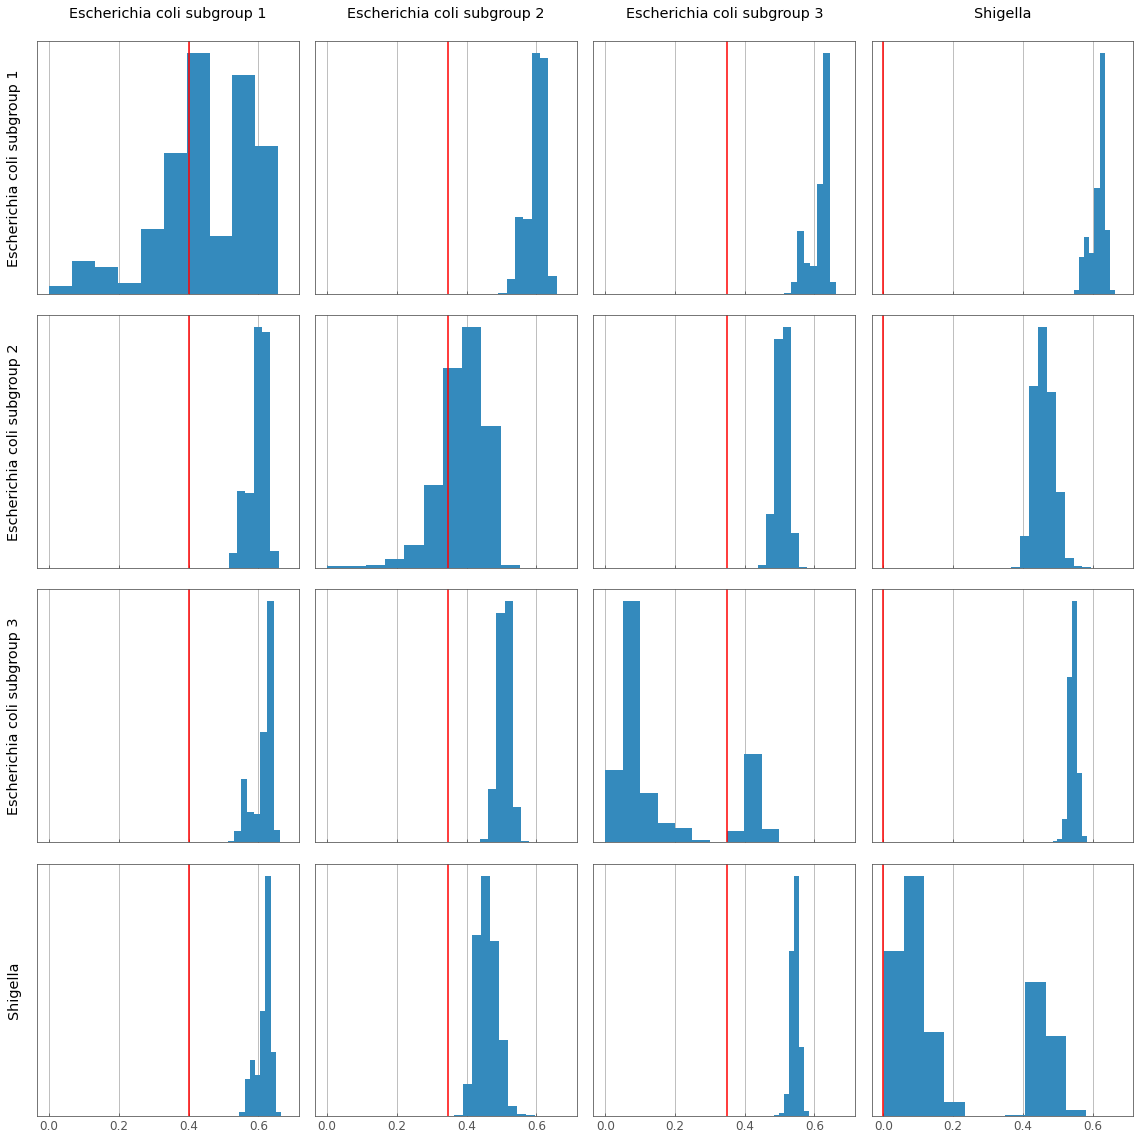

In [26]:
_tids = [1892, 1893, 1894, 1863]
_taxa = [taxa[id] for id in _tids]
_names = [taxon.name for taxon in _taxa]
n = len(_tids)

fig, axs = plt.subplots(n, n, figsize=(16, 16), sharex=True, sharey=False)
set_grid_headers(axs, _names, _names, vertical=True)

for i, tid1 in enumerate(_tids):
    for j, tid2 in enumerate(_tids):
        taxon2 = taxa[tid2]
        
        ax = axs[i, j]
        ax.grid(False, axis='y')
        ax.set_yticks([])
        # ax.yaxis.set_visible(False)
        
        if i == j:
            dists = dists_flat(subtree_gidxs[tid1])
        else:
            dists = dists_flat(subtree_gidxs[tid1], subtree_gidxs[tid2])
            
        ax.hist(dists)
        ax.axvline(taxon2.distance_threshold, color='red')
        
fig.tight_layout()